In [252]:
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

## Comparing selections by team vs. selections by pure max

In [260]:
processed = Path('../data/processed')
predictions = pd.read_pickle(Path(processed) / 'main_predictions.pkl')
predictions = predictions.loc[:, ['Win', 'EstProb', 'BAT_TEAM_ID', 'year', 'Date']].copy()
predictions = predictions.astype({
    'Win': 'int',
    'EstProb': 'float',
    'year': 'int',
})

In [269]:
selections1 = predictions.sort_values(['Date', 'EstProb'], ascending=[True, False])
selections1['pick_order'] = selections1.groupby(['Date']).cumcount() + 1
selections1 = selections1[selections1.pick_order <= 2]

selections1['Points'] = selections1.groupby('Date')['Win'].transform('prod')
selections1['ExpPoints'] = selections1.groupby('Date')['EstProb'].transform('prod')
selections1 = selections1.reset_index().set_index(['Date', 'pick_order'])

top_by_team = predictions.sort_values(['Date', 'GAME_ID', 'BAT_TEAM_ID', 'EstProb'], ascending=[True, True, True, False])
top_by_team['id'] = top_by_team.groupby(['GAME_ID', 'BAT_TEAM_ID']).ngroup()
top_by_team['pick_order'] = top_by_team.groupby(['GAME_ID', 'BAT_TEAM_ID']).cumcount() + 1
top_by_team = top_by_team.loc[top_by_team.pick_order <= 2].copy()
top_by_team['num_pick'] = top_by_team.groupby(['GAME_ID', 'BAT_TEAM_ID'])['pick_order'].transform('max')
top_by_team = top_by_team.loc[top_by_team.num_pick == 2].copy()

top_by_team['Points'] = top_by_team.groupby('id')['Win'].transform('prod')
top_by_team['ExpPointsPre'] = top_by_team.groupby('id')['EstProb'].transform('prod')
top_by_team['ExpPoints'] = top_by_team['ExpPointsPre'] + (.0164 - .0157) + (.9891 - .9728)*top_by_team['ExpPointsPre']

top_by_team = top_by_team.sort_values(
    ['Date', 'ExpPoints', 'GAME_ID', 'BAT_TEAM_ID', 'EstProb'],
    ascending=[True, False, True, True, False]
)
top_by_team['group_pick_order'] = top_by_team.groupby(['Date']).cumcount() + 1

selections2 = top_by_team.loc[top_by_team.group_pick_order <= 2].copy()
selections2 = selections2.reset_index().set_index(['Date', 'pick_order'])
del selections2['group_pick_order']
del selections2['id']
del selections2['ExpPointsPre']
del selections2['num_pick']

temp1 = selections1.groupby('Date')[['ExpPoints']].first()
temp2 = selections2.groupby('Date')[['ExpPoints']].first()
temp2.columns = ['ExpPoints2']

compare = pd.merge(temp1, temp2, on=['Date'], how='left')
compare['ChooseTeam'] = compare['ExpPoints2'] > compare['ExpPoints']

selections1 = pd.merge(selections1, compare['ChooseTeam'], on=['Date'], how='left')
selections2 = pd.merge(selections2, compare['ChooseTeam'], on=['Date'], how='left')

select1 = selections1[selections1.ChooseTeam == False]
select2 = selections2[selections2.ChooseTeam == True]
selections = select1.append(select2)

selections = selections.sort_values('Date')
selections['pick_order'] = selections.groupby(['Date']).cumcount()+1
selections = selections[['GAME_ID', 'BAT_ID', 'EstProb', 'ExpPoints', 'pick_order', 'ChooseTeam']]

In [270]:
selections.ChooseTeam.value_counts()

False    20296
True     13656
Name: ChooseTeam, dtype: int64

                            OLS Regression Results                            
Dep. Variable:              PointsDif   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     21.85
Date:                Mon, 05 Apr 2021   Prob (F-statistic):           2.96e-06
Time:                        09:19:00   Log-Likelihood:                -25710.
No. Observations:               33952   AIC:                         5.142e+04
Df Residuals:                   33950   BIC:                         5.144e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0094      0.004     -2.519   

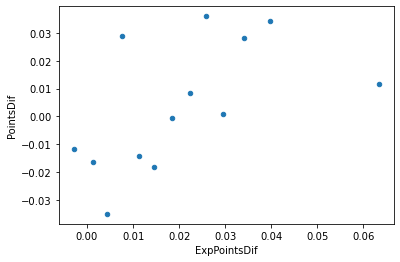

In [20]:
temp3['bin'] = pd.qcut(temp3['ExpPointsDif'], 15, duplicates='drop')

dots = temp3.groupby(['bin'])[['ExpPointsDif', 'PointsDif']].agg('mean')
dots = dots.reset_index()
dots.plot.scatter('ExpPointsDif', 'PointsDif')

model = sm.ols('PointsDif ~ ExpPointsDif', data=temp3)
results = model.fit()
temp3['pred'] = results.predict()

print(results.summary())

In [10]:
temp3['ChooseTeam'] = temp3['pred'] < 0

In [11]:
temp3.ChooseTeam.value_counts()

True     17032
False    16920
Name: ChooseTeam, dtype: int64

In [12]:
choose_team = temp3.groupby('Date')['ChooseTeam'].first()

In [13]:
s = pd.merge(selections1, selections2, on=['Date', 'pick_order'], how='left')

In [14]:
abc = pd.merge(s, choose_team, on=['Date'], how='left')

In [15]:
abc['Win'] = np.where(
    abc['ChooseTeam'] == 1,
    abc['Win_x'],
    abc['Win_y']
)

In [16]:
abc['Win']

Date
1921-04-13    1.0
1921-04-13    1.0
1921-04-14    1.0
1921-04-14    1.0
1921-04-15    1.0
             ... 
2020-09-25    1.0
2020-09-26    0.0
2020-09-26    0.0
2020-09-27    1.0
2020-09-27    0.0
Name: Win, Length: 34390, dtype: float64

## How selections by team compare to expected

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5474.
Date:                Sat, 03 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:28:00   Log-Likelihood:            -4.7515e+05
No. Observations:              659248   AIC:                         9.503e+05
Df Residuals:                  659246   BIC:                         9.503e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0179      0.007     -2.451      0.0

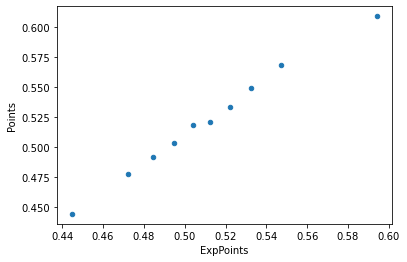

In [21]:
top_by_team['bin'] = pd.qcut(top_by_team['ExpPoints'], 10, duplicates='drop')

dots = top_by_team.groupby(['bin'])[['ExpPoints', 'Points']].agg('mean')
dots = dots.reset_index()
dots.plot.scatter('ExpPoints', 'Points')

model = sm.ols('Points ~ ExpPoints', data=top_by_team)
results = model.fit()
print(results.summary())

## How selections by pute max compare to expected

<AxesSubplot:xlabel='ExpPoints', ylabel='Points'>

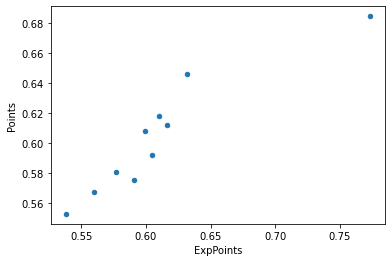

In [21]:
selections1['bin'] = pd.qcut(selections1['ExpPoints'], 10, duplicates='drop')

dots2 = selections1.groupby(['bin'])[['ExpPoints', 'Points']].agg('mean')
dots2 = dots2.reset_index()
dots2.plot.scatter('ExpPoints', 'Points')

## Estimating difference

In [271]:
processed = Path('../data/processed')
predictions = pd.read_pickle(Path(processed) / 'main_predictions.pkl')

In [272]:
small_pred = predictions.loc[predictions.year >= 2000, ['Date', 'EstProb', 'Win', 'BAT_TEAM_ID']]
small_pred = small_pred.reset_index()
small_pred['id'] = small_pred.groupby('BAT_ID').ngroup()

In [273]:
test = pd.merge(small_pred, small_pred, on=['Date'])
test = test[test.id_x < test.id_y].copy()

In [289]:
test['Points'] = (test['Win_x'] * test['Win_y']).astype('int')
test['ExpPoints'] = (test['EstProb_x'] * test['EstProb_y']).astype('float')
test['Err1'] = test['Win_x'] - test['EstProb_x']
test['Err2'] = test['Win_y'] - test['EstProb_y']

In [290]:
test['bin'] = pd.qcut(test['ExpPoints'], 50, duplicates='drop')
dots = test.groupby(['bin'])[['ExpPoints', 'Points']].agg('mean')
dots = dots.reset_index()
model = sm.ols('Points ~ ExpPoints', data=test)
results1 = model.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                 5.936e+05
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:27:28   Log-Likelihood:            -4.2402e+07
No. Observations:            59414946   AIC:                         8.480e+07
Df Residuals:                59414944   BIC:                         8.480e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0157      0.001     28.303      0.0

In [291]:
test2 = test[(test.GAME_ID_x == test.GAME_ID_y) & (test.BAT_TEAM_ID_x == test.BAT_TEAM_ID_y)].copy()
test2['bin'] = pd.qcut(test2['ExpPoints'], 50, duplicates='drop')
dots2 = test2.groupby(['bin'])[['ExpPoints', 'Points']].agg('mean')
dots2 = dots2.reset_index()

model = sm.ols('Points ~ ExpPoints', data=test2)
results2 = model.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                 2.143e+04
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:27:36   Log-Likelihood:            -1.3910e+06
No. Observations:             1945436   AIC:                         2.782e+06
Df Residuals:                 1945434   BIC:                         2.782e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0174      0.003      5.867      0.0

<AxesSubplot:xlabel='ExpPoints', ylabel='Points'>

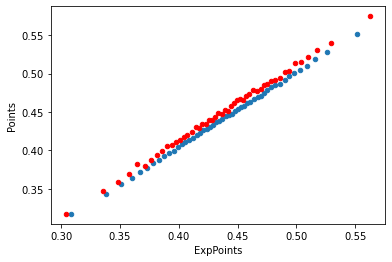

In [292]:
ax1 = dots.plot(kind='scatter', x='ExpPoints', y='Points')
dots2.plot(kind='scatter', x='ExpPoints', y='Points', ax=ax1, color='r')

In [293]:
def dif(x, results1, results2):
    pred = (results2.params['Intercept'] - results1.params['Intercept']) + \
        (results2.params['ExpPoints']-results1.params['ExpPoints'])*x
    return pred

In [294]:
dif(1, results1, results2)

0.01796231581661699

In [295]:
(.0164 - .0157) + (.9891 - .9728)

0.016999999999999984

## Partial Covariance

In [ ]:
# prob(A=1) = p1
# prob(B=1) = p2

# Exp(A) = p1
# Exp(B) = p2

# var(A) = p1(1-p1)
# var(B) = p2(1-p2)

# Exp(AB) = p3

# rho =  (Exp(AB) - p1 * p2) / ( sqrt(p1*(1-p1)) * sqrt(p2*(1-p2)) )

# Exp(AB) = rho * ( sqrt(p1*(1-p1)) * sqrt(p2*(1-p2)) ) + p1*p2

# P(AB = 1) = Exp(AB)

# P(B|A=1) = P(AB = 1) / P(A = 1)
#     = (rho * ( sqrt(p1*(1-p1)) * sqrt(p2*(1-p2)) ) + p1*p2) / p1

In [ ]:
dif = 

In [330]:
test2[['Err1', 'Err2']].corr()

,Err1,Err2
Err1,1.000000,0.039007
Err2,0.039007,1.000000


In [343]:
Exp1 = test2.Err1.mean()
Exp2 = test2.Err2.mean()
SD1 = test2.Err1.std()
SD2 = test2.Err2.std()

test2['AB'] = test2.Err1 * test2.Err2
Exp12 = test2['AB'].mean()

rho = (Exp12 - Exp1 * Exp2) / (SD1 * SD2)
rho

0.03900654476289184

In [353]:
test2.loc[:, ['Win_x', 'Win_y']].corr()

,Win_x,Win_y
Win_x,1.000000,0.040613
Win_y,0.040613,1.000000


In [352]:
test2.head()

,GAME_ID_x,BAT_ID_x,Date,EstProb_x,Win_x,BAT_TEAM_ID_x,id_x,GAME_ID_y,BAT_ID_y,EstProb_y,...,id_y,Points,ExpPoints,bin,Err1,Err2,ExpSD_x,ExpSD_y,ExpPoints2,AB
201,COL200005020,guerv001,2000-05-02,0.818739,0,MON,598,COL200005020,whitr001,0.785696,...,1517,0,0.643280,"(0.538, 0.861]",-0.818739,0.214304,0.385234,0.410338,0.649603,-0.175459
212,COL200005020,guerv001,2000-05-02,0.818739,0,MON,598,COL200005020,vidrj001,0.743022,...,1490,0,0.608341,"(0.538, 0.861]",-0.818739,0.256978,0.385234,0.436967,0.615074,-0.210398
227,COL200005020,guerv001,2000-05-02,0.818739,0,MON,598,COL200005020,stevl001,0.724982,...,1378,0,0.593571,"(0.538, 0.861]",-0.818739,0.275018,0.385234,0.446523,0.600452,-0.225168
598,COL200005020,cabro001,2000-05-02,0.785696,1,MON,223,COL200005020,guerv001,0.818739,...,598,0,0.643280,"(0.538, 0.861]",0.214304,-0.818739,0.410338,0.385234,0.649603,-0.175459
599,COL200005020,cabro001,2000-05-02,0.785696,1,MON,223,COL200005020,whitr001,0.785696,...,1517,1,0.617319,"(0.538, 0.861]",0.214304,0.214304,0.410338,0.410338,0.624054,0.045926


In [344]:
test2['ExpSD_x'] = np.sqrt( test2['EstProb_x'] * (1-test2['EstProb_x']) )
test2['ExpSD_y'] = np.sqrt( test2['EstProb_y'] * (1-test2['EstProb_y']) )
test2['ExpPoints2'] = .04 * (test2['ExpSD_x']*test2['ExpSD_y']) + test2['EstProb_x']*test2['EstProb_y']

In [345]:
test2

,GAME_ID_x,BAT_ID_x,Date,EstProb_x,Win_x,BAT_TEAM_ID_x,id_x,GAME_ID_y,BAT_ID_y,EstProb_y,...,id_y,Points,ExpPoints,bin,Err1,Err2,ExpSD_x,ExpSD_y,ExpPoints2,AB
201,COL200005020,guerv001,2000-05-02,0.818739,0,MON,598,COL200005020,whitr001,0.785696,...,1517,0,0.643280,"(0.538, 0.861]",-0.818739,0.214304,0.385234,0.410338,0.649603,-0.175459
212,COL200005020,guerv001,2000-05-02,0.818739,0,MON,598,COL200005020,vidrj001,0.743022,...,1490,0,0.608341,"(0.538, 0.861]",-0.818739,0.256978,0.385234,0.436967,0.615074,-0.210398
227,COL200005020,guerv001,2000-05-02,0.818739,0,MON,598,COL200005020,stevl001,0.724982,...,1378,0,0.593571,"(0.538, 0.861]",-0.818739,0.275018,0.385234,0.446523,0.600452,-0.225168
598,COL200005020,cabro001,2000-05-02,0.785696,1,MON,223,COL200005020,guerv001,0.818739,...,598,0,0.643280,"(0.538, 0.861]",0.214304,-0.818739,0.410338,0.385234,0.649603,-0.175459
599,COL200005020,cabro001,2000-05-02,0.785696,1,MON,223,COL200005020,whitr001,0.785696,...,1517,1,0.617319,"(0.538, 0.861]",0.214304,0.214304,0.410338,0.410338,0.624054,0.045926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119485434,CHN201504050,jay-j001,2015-04-05,0.620176,1,SLN,736,CHN201504050,peraj001,0.653231,...,1115,1,0.405118,"(0.402, 0.406]",0.379824,0.346769,0.485343,0.475941,0.414358,0.131711
119485437,CHN201504050,jay-j001,2015-04-05,0.620176,1,SLN,736,CHN201504050,wongk001,0.593029,...,1544,0,0.367782,"(0.362, 0.368]",0.379824,-0.593029,0.485343,0.491269,0.377320,-0.225247
119485461,CHN201504050,lastt001,2015-04-05,0.554688,1,CHN,832,CHN201504050,rizza001,0.667974,...,1224,0,0.370517,"(0.368, 0.374]",0.445312,-0.667974,0.497000,0.470940,0.379879,-0.297456
119485467,CHN201504050,lastt001,2015-04-05,0.554688,1,CHN,832,CHN201504050,olt-m001,0.524962,...,1064,0,0.291190,"(0.0902, 0.326]",0.445312,-0.524962,0.497000,0.499377,0.301118,-0.233772


In [301]:
test4 = test[(test.GAME_ID_x == test.GAME_ID_y) & (test.BAT_TEAM_ID_x != test.BAT_TEAM_ID_y)].copy()

In [328]:
test4[['Err1', 'Err2']].corr()

,Err1,Err2
Err1,1.000000,0.002575
Err2,0.002575,1.000000


In [329]:
test4[['Win_x', 'Win_y']].corr()

,Win_x,Win_y
Win_x,1.000000,0.004129
Win_y,0.004129,1.000000


In [303]:
test3 = test[(test.GAME_ID_x != test.GAME_ID_y)].copy()

In [304]:
test3[['Err1', 'Err2']].corr()

,Err1,Err2
Err1,1.000000,0.000596
Err2,0.000596,1.000000


In [327]:
test3[['Win_x', 'Win_y']].corr()

,Win_x,Win_y
Win_x,1.000000,0.001075
Win_y,0.001075,1.000000
